## 0.0: packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import joblib
import numpy as np
import random
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, model_selection, ensemble, svm, naive_bayes, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error, roc_curve, auc
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sklearn
import pyodbc
import sys
import sqlalchemy
import urllib
from datetime import date
from collections import Counter
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
import time
import shap
from future.standard_library import install_aliases

In [2]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",100)

## 0.1: pull dask and start client

In [3]:
from dask.distributed import Client
import dask
import dask_xgboost
from dask import dataframe as dd
from dask_ml.model_selection import train_test_split
import dask_ml
from dask_ml.xgboost import XGBClassifier

client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:36541 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 128.67 GB


## 0.2: read in data

In [4]:
%%time
df_final = pd.read_csv('/mnt/h/02_NoPHI/DataScience/01_ModelScripts/MA_ChartChase/df_final_combined.csv')

CPU times: user 3min 1s, sys: 16 s, total: 3min 17s
Wall time: 3min 55s


## 0.2b: compare to reading in with dask

In [5]:
%%time
dd_final = dd.read_csv('/mnt/h/02_NoPHI/DataScience/01_ModelScripts/MA_ChartChase/df_final_combined.csv',
                      dtype={"FacilityType":object})

CPU times: user 215 ms, sys: 308 ms, total: 523 ms
Wall time: 526 ms


In [6]:
dd_final.head()

,Unnamed: 0,clientDSClaimKey,clientDSMemberKey,clientDB,diagnosisTypeCode,CC,claimType,pro_claim,op_claim,ip_claim,service_year,renderingProviderIdentifier,ProviderSpecialty,CombinedProviderSpecialty,FacilityType,Age,payment_year,StateCountyCode,PlanBenefitPackageId,MCOContractNumber,sex,MedicaidDualStatusCode,NewMedicareBeneficiaryMedicaidStatusFlag,DefaultRiskFactorCode,RAFactorTypeCode,Hospice,OriginalReasonforEntitlementCode,medicaidIndicator,Institutional,LTIFlag,EGHPFlag,ESRD_MMR_Flag,OREC_ESRD,OREC_disabled,FrailtyIndicator,OREC,LISPremiumSubsidy,RiskAdjusterFactorA,defaultRFcode,max_month,Duration,rxClaimTotal,medClaimTotal,1_noncaptured,2_noncaptured,6_noncaptured,8_noncaptured,9_noncaptured,10_noncaptured,11_noncaptured,...,pathology and laboratory_immunology,pathology and laboratory_in vivo (transcutaneous) lab procedures,pathology and laboratory_microbiology,pathology and laboratory_organ or disease-oriented panels,pathology and laboratory_other procedures,pathology and laboratory_reproductive medicine procedures,pathology and laboratory_surgical pathology,pathology and laboratory_therapeutic drug assays,pathology and laboratory_transfusion medicine,pathology and laboratory_urinalysis,radiology_bone/joint studies,radiology_breast mammography,radiology_diagnostic radiology,radiology_diagnostic ultrasound,radiology_nuclear medicine,radiology_radiation oncology,radiology_radiologic guidance,surgery_auditory system,surgery_cardiovascular system,surgery_digestive system,surgery_endocrine system,surgery_eye and ocular adnexa,surgery_female genital system,surgery_general,surgery_hemic and lymphatic systems,surgery_integumentary system,surgery_male genital system,surgery_maternity care and delivery,surgery_mediastinum and diaphragm,surgery_musculoskeletal system,surgery_nervous system,surgery_reproductive system and intersex,surgery_respiratory system,surgery_urinary system,Ambulance,ER,Home Health,Mental Health Care,Outpatient Hospital,PCP Visit,Renal Dialysis,Specialist Visit,Medical MOOP,PCP Visit_copay,Specialist Visit_copay,PCP Visit_coinsure,Specialist Visit_coinsure,IP,OP,P
0,0,773,20590,Pareto_Capital_2019Test,2,78.0,P,1,0,0,2017,01187601,Family Practice,PCP,11.0,73.0,2018.0,39590.0,4.0,H3962,M,0.0,,,CN,,0.0,,,,,0.0,0.0,0.0,N,0.0,0.0,1.361,,2018-12-31,95.0,681.64,370.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,3400.0,10.0,25.0,NaN,NaN,NaN,NaN,9.0
1,1,1245,9788,Pareto_Capital_2019Test,2,19.0,P,1,0,0,2017,01478003,Neurology,Neurology,11.0,75.0,2018.0,39110.0,4.0,H3962,M,0.0,,,CN,,0.0,,,,,0.0,0.0,0.0,N,0.0,0.0,2.455,,2018-12-31,95.0,2688.22,8104.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,9.0,2.0,NaN,2.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,3400.0,10.0,25.0,NaN,NaN,NaN,15.0,50.0
2,2,1360,21258,Pareto_Capital_2019Test,2,27.0,IP,0,0,1,2018,390183,NaN,NaN,1.0,72.0,2019.0,39650.0,7.0,H3962,M,0.0,,,CN,,0.0,,,,,0.0,0.0,0.0,N,0.0,0.0,2.762,,2019-12-31,46.0,6129.86,83170.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,20.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,14.0,3.0,NaN,NaN,NaN,NaN,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6700.0,5.0,30.0,NaN,NaN,10.0,15.0,146.0
3,3,2543,32389,Pareto_Capital_2019Test,2,71.0,P,1,0,0,2018,3B0138,NaN,NaN,23.0,49.0,2019.0,39350.0,7.0,H3962,F,3.0,,,CP,,1.0,,,,,0.0,0.0,1.0,N,1.0,0.0,5.243,,2019-12-31,35.0,8035.14,22843.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6700.0,5.0,30.0,NaN,NaN,2.0,7.0,30.0
4,4,2686,37019,Pareto_Capital_2019Test,2,111.0,P,1,0,0,2018,50113110,Physicians Assist/PCP,PCP,11.0,73.0,2019.0,39280.0,17.0,H3923,F,0.0

In [7]:
len(dd_final)

2684949

In [8]:
df_final = df_final[df_final['service_year'].isin([2018])]

In [9]:
dd_final = dd_final[dd_final['service_year'].isin([2018])]

In [10]:
df_final = df_final.drop(columns='Unnamed: 0')

In [11]:
len(df_final)

1469943

In [12]:
len(dd_final)

1469943

In [13]:
df_final.head()

,clientDSClaimKey,clientDSMemberKey,clientDB,diagnosisTypeCode,CC,claimType,pro_claim,op_claim,ip_claim,service_year,renderingProviderIdentifier,ProviderSpecialty,CombinedProviderSpecialty,FacilityType,Age,payment_year,StateCountyCode,PlanBenefitPackageId,MCOContractNumber,sex,MedicaidDualStatusCode,NewMedicareBeneficiaryMedicaidStatusFlag,DefaultRiskFactorCode,RAFactorTypeCode,Hospice,OriginalReasonforEntitlementCode,medicaidIndicator,Institutional,LTIFlag,EGHPFlag,ESRD_MMR_Flag,OREC_ESRD,OREC_disabled,FrailtyIndicator,OREC,LISPremiumSubsidy,RiskAdjusterFactorA,defaultRFcode,max_month,Duration,rxClaimTotal,medClaimTotal,1_noncaptured,2_noncaptured,6_noncaptured,8_noncaptured,9_noncaptured,10_noncaptured,11_noncaptured,12_noncaptured,...,pathology and laboratory_immunology,pathology and laboratory_in vivo (transcutaneous) lab procedures,pathology and laboratory_microbiology,pathology and laboratory_organ or disease-oriented panels,pathology and laboratory_other procedures,pathology and laboratory_reproductive medicine procedures,pathology and laboratory_surgical pathology,pathology and laboratory_therapeutic drug assays,pathology and laboratory_transfusion medicine,pathology and laboratory_urinalysis,radiology_bone/joint studies,radiology_breast mammography,radiology_diagnostic radiology,radiology_diagnostic ultrasound,radiology_nuclear medicine,radiology_radiation oncology,radiology_radiologic guidance,surgery_auditory system,surgery_cardiovascular system,surgery_digestive system,surgery_endocrine system,surgery_eye and ocular adnexa,surgery_female genital system,surgery_general,surgery_hemic and lymphatic systems,surgery_integumentary system,surgery_male genital system,surgery_maternity care and delivery,surgery_mediastinum and diaphragm,surgery_musculoskeletal system,surgery_nervous system,surgery_reproductive system and intersex,surgery_respiratory system,surgery_urinary system,Ambulance,ER,Home Health,Mental Health Care,Outpatient Hospital,PCP Visit,Renal Dialysis,Specialist Visit,Medical MOOP,PCP Visit_copay,Specialist Visit_copay,PCP Visit_coinsure,Specialist Visit_coinsure,IP,OP,P
2,1360,21258,Pareto_Capital_2019Test,2,27.0,IP,0,0,1,2018,390183,NaN,NaN,1,72.0,2019.0,39650.0,7.0,H3962,M,0.0,,,CN,,0.0,,,,,0.0,0.0,0.0,N,0.0,0.0,2.762,,2019-12-31,46.0,6129.86,83170.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,20.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,14.0,3.0,NaN,NaN,NaN,NaN,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6700.0,5.0,30.0,NaN,NaN,10.0,15.0,146.0
3,2543,32389,Pareto_Capital_2019Test,2,71.0,P,1,0,0,2018,3B0138,NaN,NaN,23,49.0,2019.0,39350.0,7.0,H3962,F,3.0,,,CP,,1.0,,,,,0.0,0.0,1.0,N,1.0,0.0,5.243,,2019-12-31,35.0,8035.14,22843.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6700.0,5.0,30.0,NaN,NaN,2.0,7.0,30.0
4,2686,37019,Pareto_Capital_2019Test,2,111.0,P,1,0,0,2018,50113110,Physicians Assist/PCP,PCP,11,73.0,2019.0,39280.0,17.0,H3923,F,0.0,,,CN,,0.0,,,,,0.0,0.0,0.0,N,0.0,0.0,0.911,,2019-12-31,104.0,74.92,21342.55,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,2.0,6.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,3400.0,10.0,25.0,NaN,NaN,1.0,12.0,71.0
6,4146,28804,Pareto_Capital_2019Test,2,72.0,P,1,0,0,2018,50060997,Neurological Surgery,Surgery - Neurology,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,865.64,4403.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,32.0
7,4735,23611,Pareto_Capital_2019Test,2,18.0,P,1,0,0,2018,50099392,Internal Medicine,Internal 

## 0.3: etl data

In [14]:
#turn categorical data to encoded
df_final = df_final.merge(pd.get_dummies(df_final['RAFactorTypeCode']), how='inner',left_index=True,right_index=True)
df_final = df_final.merge(pd.get_dummies(df_final['CombinedProviderSpecialty']), how='inner',left_index=True,right_index=True)

df_final = df_final.drop(columns=['RAFactorTypeCode','CombinedProviderSpecialty'])

In [15]:
df_final['EGHPFlag'].replace(('Y', 'N'), (1, 0), inplace=True)
df_final['LTIFlag'].replace(('Y', 'N'), (1, 0), inplace=True)
df_final['medicaidIndicator'].replace(('Y', 'N'), (1, 0), inplace=True)
df_final['FrailtyIndicator'].replace(('Y', 'N'), (1, 0), inplace=True)
df_final['sex'].replace(('M', 'F'), (1, 0), inplace=True)

In [16]:
df_final['EGHPFlag'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['LTIFlag'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['NewMedicareBeneficiaryMedicaidStatusFlag'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['FacilityType'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['DefaultRiskFactorCode'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['medicaidIndicator'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['Institutional'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['FrailtyIndicator'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['Hospice_x'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_final['sex'].replace(r'^\s*$', np.nan, regex=True, inplace = True)

## 0.4: prepare for modeling

In [17]:
features = list(set(df_final.columns.tolist()) - set(['CC','event','clientDSMemberKey','clientDSClaimKey','clientDB','service_year'
                                                      'StateCountyCode','MCOContractNumber','renderingProviderIdentifier',
                                                      'CombinedProviderSpecialty','payment_year','max_month','duration',
                                       'PlanBenefitPackageId','','fill_year','claimType','defaultRFcode','ProviderSpecialty','FacilityType']))

In [18]:
df_final['medClaimTotal'] = df_final['medClaimTotal'].astype(float)
df_final['rxClaimTotal'] = df_final['rxClaimTotal'].astype(float)

In [19]:
df_final = df_final.drop_duplicates()

In [20]:
def modelfit_classification(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
    print(classification_report(y_train, dtrain_predictions))
    print(confusion_matrix(y_train, dtrain_predictions))
    
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_test.values, dtest_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_test, dtest_predprob))
    print(classification_report(y_test, dtest_predictions))
    print(confusion_matrix(y_test, dtest_predictions))
                    
    feat_imp = pd.DataFrame({'features':features_current})
    feat_imp['importance'] = alg.feature_importances_
    feat_imp = feat_imp.sort_values(by = 'importance', ascending=False).head(20)
    feat_imp.plot(x='features', y='importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [21]:
def modelfit_regression(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
        
    #Print model report:
    print("\nModel Report")
    print("R2 %s" % r2_score(y_train, dtrain_predictions))
    print("Mean Squared Error %s" % mean_squared_error(y_train, dtrain_predictions))
    print("Mean Absolute Error %s" % mean_absolute_error(y_train, dtrain_predictions))
    
    print("R2 %s" % r2_score(y_test, dtest_predictions))
    print("Mean Squared Error %s" % mean_squared_error(y_test, dtest_predictions))
    print("Mean Absolute Error %s" % mean_absolute_error(y_test, dtest_predictions))
                        
    feat_imp = pd.DataFrame({'features':features_current})
    feat_imp['importance'] = alg.feature_importances_
    feat_imp = feat_imp.sort_values(by = 'importance', ascending=False).head(20)
    feat_imp.plot(x='features', y='importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [22]:
condition=114

target_cond = str(condition)+'_captured'
df_final['event'] = np.where(df_final['CC'] == condition, 1, 0)
features_current=features.copy()
features_current.remove(target_cond)

## 0.5: convert pandas dataframe to dask dataframe

In [23]:
%%time
dd_final = dd.from_pandas(df_final.drop_duplicates(),npartitions=10)

CPU times: user 31.5 s, sys: 3.58 s, total: 35.1 s
Wall time: 33.9 s


In [24]:
len(dd_final)

1469943

In [25]:
len(df_final)

1469943

In [ ]:
##test 108

## 1.0: modeling with dask

In [26]:
%%time
X_train, X_test, y_train, y_test = train_test_split(dd_final[features_current], dd_final['event'], test_size=0.1,random_state=5)

params = {"learning_rate":0.1,
         "n_estimators":100,
         "n_jobs":4,
         "max_depth":8,
         "min_child_weight":1,
         "gamma":0,
         "subsample":0.8,
         "colsample_bytree":0.8,
         "objective":'binary:logistic',
         "scale_pos_weight":10,
         "max_delta_step":6,
         "reg_alpha":100,
         "seed":27}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

CPU times: user 13 s, sys: 11.4 s, total: 24.4 s
Wall time: 2min 34s


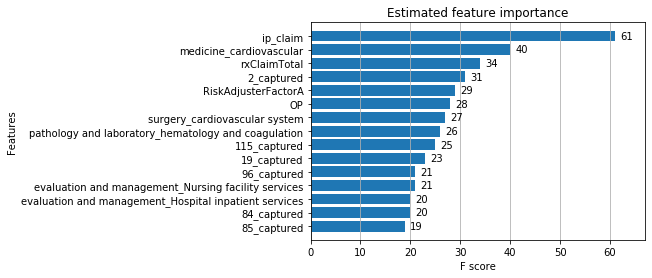

In [27]:
ax = xgb.plot_importance(bst, height=0.8, max_num_features=15)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [28]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()
y_hat

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [29]:
y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

In [30]:
print(auc(fpr, tpr))

0.9605059539000484


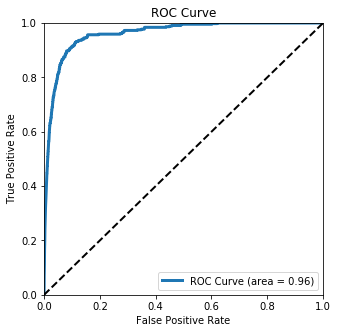

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

In [32]:
y_hat[y_hat>.5]=1

In [33]:
y_hat[y_hat<=.5]=0

In [34]:
print(confusion_matrix(y_test, y_hat))

[[145552    472]
 [   330    109]]


In [118]:
#save model
bst.save_model('xgb_dask_test1')

In [70]:
#load model
bst = xgb.Booster(model_file='xgb_dask_test1')

In [137]:
joblib.dump(bst, 'xgb_dask_test1'+'.pkl')

['xgb_dask_test1.pkl']

## 1.1 test gridsearch

In [ ]:
X_train_dask = dd.from_pandas(X_train, npartitions=10)
X_test_dask = dd.from_pandas(X_test, npartitions=10)
y_train_dask = dd.from_pandas(y_train, npartitions=10)

import dask
from dask.distributed import Client, progress        # task distribution

client = Client()
param_grid = {
    'n_estimators' : [500 , 750 , 1000],
    'max_depth': [15, 25 , 35  , -1],
    'colsample_bytree' : [ 0.7 , 0.9],
    'gamma' : [0.2 , 0.3 , 0.5],
    'subsample' : [ 0.7 , 0.8 , 0.9] ,
    'alpha' : [3, 4, 5],
    'learning_rate' : [0.05, 0.01, 0.008]
}
import dask_xgboost as dxgb
from dask_ml.model_selection import GridSearchCV as GSV
from sklearn.model_selection import GroupKFold
clf = dxgb.XGBClassifier(random_state= 100,missing = -999) 
skf = GroupKFold(n_splits=3)
grid_search = GSV(clf, param_grid, scoring='roc_auc', refit=True ,
                           cv=skf, return_train_score=True)
grid_search.fit(X_train_dask.to_dask_array(), y_train_dask.to_dask_array()) 
print(grid_search.best_params_)
print(grid_search.best_score_ )

## 1.2 compare to normal xgb


Model Report
Accuracy : 0.9958
AUC Score (Train): 0.962173
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1318786
           1       0.23      0.13      0.17      4162

    accuracy                           1.00   1322948
   macro avg       0.61      0.57      0.58   1322948
weighted avg       0.99      1.00      1.00   1322948

[[1316896    1890]
 [   3605     557]]

Model Report
Accuracy : 0.9958
AUC Score (Train): 0.962643
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146543
           1       0.21      0.13      0.16       452

    accuracy                           1.00    146995
   macro avg       0.60      0.57      0.58    146995
weighted avg       0.99      1.00      1.00    146995

[[146313    230]
 [   392     60]]


None

CPU times: user 46min 53s, sys: 7.8 s, total: 47min 1s
Wall time: 12min 45s


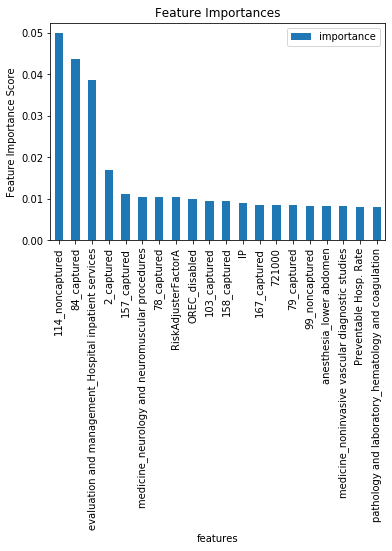

In [60]:
%%time
condition=114

target_cond = str(condition)+'_captured'
df_final['event'] = np.where(df_final['CC'] == condition, 1, 0)
features_current=features.copy()
features_current.remove(target_cond)

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_final[features_current], df_final['event'], test_size=0.1,random_state=5)

xgb_train = XGBClassifier(
         learning_rate =0.1,
         n_estimators=50,
         n_jobs=4,
         max_depth=6,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         scale_pos_weight=7,
         max_delta_step=6,
         reg_alpha=100,
         seed=27)
display(modelfit_classification(xgb_train, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=3, early_stopping_rounds=50))

#joblib.dump(xgb_train, 'Pickles/xgb_MA_ChartChase_'+str(condition)+'.pkl')

## 1.3 test applying xgb dask models

In [38]:
import gc

server = input("Server: ")
database = input("Database: ")
year = input("Year: ")

install_aliases()
warnings.filterwarnings("ignore")
cxn_str="DSN={0};DATABASE={1};Trusted_Connection=yes".format(server, database)                                   
params = urllib.parse.quote_plus(cxn_str)
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_001_MemberInfo')
df_mem = pd.DataFrame(result.fetchall(),columns = result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_003_capturedconditions')
df_cc = pd.DataFrame(result.fetchall(),columns=result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_004_nonscoredconditions')
df_noncc = pd.DataFrame(result.fetchall(),columns=result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_005_procedures')
df_procs = pd.DataFrame(result.fetchall(),columns=result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_006_drugs')
df_drugs = pd.DataFrame(result.fetchall(),columns=result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_007_contracts')
df_mco = pd.DataFrame(result.fetchall(),columns=result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_008_tpd')
df_tpd = pd.DataFrame(result.fetchall(),columns=result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_009_indClaims')
df_indclaims = pd.DataFrame(result.fetchall(),columns=result.keys())

result = engine.execute('SELECT DISTINCT * FROM DS_ChartChase_MA_010_provider')
df_prov = pd.DataFrame(result.fetchall(),columns=result.keys())
print("Data Loaded")


##etl data   
df_copay = df_mco[['memberKey','clientDB','service_year','attribute','Copayment']][~df_mco['attribute'].isin(['Medical MOOP','Medical Deductible'])]
df_price = df_mco[['memberKey','clientDB','service_year','attribute','value']][df_mco['attribute'].isin(['Medical MOOP','Medical Deductible','PCP Visit','Specialist Visit'])]
df_copay = pd.pivot_table(df_copay, index=['memberKey','clientDB','service_year'], columns='attribute', values='Copayment', aggfunc = np.max)
df_price['copay'] = pd.to_numeric(df_price.value.str.split('.').str[0], errors='coerce', downcast='integer')
df_price['coinsurance'] = pd.to_numeric(df_price.value.str.extract('(\d+)(%)', expand = True).get(0), errors='coerce', downcast='integer')
df_pay = pd.pivot_table(df_price, index=['memberKey','clientDB','service_year'], columns='attribute', values='copay', aggfunc = np.max)
df_coinsure = pd.pivot_table(df_price, index=['memberKey','clientDB','service_year'], columns='attribute', values='coinsurance', aggfunc = np.max)
df_mco_final = df_copay.join(df_pay, rsuffix='_copay').join(df_coinsure, rsuffix='_coinsure')

df_cc['instances']=df_cc['instances'].astype('int')
df_cc_pivot = pd.pivot_table(df_cc, values='instances', index=['memberKey','clientDB','service_year'], columns=['cc']).add_suffix('_captured')

df_noncc_pivot = pd.pivot_table(df_noncc, values='instances', index=['memberKey','clientDB','service_year'], columns=['cc']).add_suffix('_noncaptured')

df_procs['description'] = df_procs['category'] + "_" + df_procs['class']
df_procs_pivot = pd.pivot_table(df_procs, values='instances', index=['memberKey','clientDB','service_year'],columns=['description'])

df_drugs.fillna(0, inplace = True)
df_drugs['drug_subclass'] = pd.to_numeric(df_drugs.drug_subclass)
df_drugs100 = df_drugs[['drug_subclass','instances']].groupby('drug_subclass').sum().sort_values('instances',ascending=False)[0:100].reset_index()
df_drugs=df_drugs.merge(df_drugs100, how='inner', on='drug_subclass').drop('instances_y',axis=1)
df_drugs_pivot = pd.pivot_table(df_drugs, values='instances_x', index=['memberKey','clientDB','fill_year'],columns=['drug_subclass'])
df_drugs_pivot.columns = df_drugs_pivot.columns.astype(str)

df_tpd_pivot = pd.pivot_table(df_tpd, values='value', index=['memberKey','clientDB','service_year'],columns=['metric'])

df_noncc_pivot = df_noncc_pivot.reset_index()
df_cc_pivot = df_cc_pivot.reset_index()
df_drugs_pivot = df_drugs_pivot.reset_index()
df_procs_pivot = df_procs_pivot.reset_index()
df_tpd_pivot = df_tpd_pivot.reset_index()
df_mco_final = df_mco_final.reset_index()

df_final = pd.merge(df_mem, df_noncc_pivot, on=['memberKey','clientDB'],how='left')
df_final = pd.merge(df_final, df_cc_pivot, on=['memberKey','clientDB'],how='left')
df_final = pd.merge(df_final, df_tpd_pivot, on=['memberKey','clientDB'],how='left')
df_final = pd.merge(df_final, df_drugs_pivot, left_on=['memberKey','clientDB'], right_on=['memberKey','clientDB'],how='left')
df_final = pd.merge(df_final, df_procs_pivot, on=['memberKey','clientDB'],how='left')
df_final = pd.merge(df_final, df_mco_final, on=['memberKey','clientDB'],how='left')
df_final = pd.merge(df_indclaims, df_final, on=['memberKey','clientDB'],how='left')
df_final = pd.merge(df_final, df_prov, on=['clientDSClaimKey','memberKey','clientDB'],how='left')

df_final = df_final.merge(pd.get_dummies(df_final['RAFactorTypeCode']), how='inner',left_index=True,right_index=True)
df_final = df_final.merge(pd.get_dummies(df_final['CombinedProviderSpecialty']), how='inner',left_index=True,right_index=True)
df_final['FacilityType'].replace(r'^\s*$', np.nan, regex=True, inplace = True)

df_final['medClaimTotal'] = df_final['medClaimTotal'].astype(float)
df_final['rxClaimTotal'] = df_final['rxClaimTotal'].astype(float)

df_final = df_final.drop_duplicates()


##filter
df_filter = df_indclaims[['clientDSClaimKey','CC']]
gc.collect()
df_predict = pd.DataFrame({'clientDSClaimKey': df_final['clientDSClaimKey']})

print('Data Ready')    
print("**************************************************")

Server:  HW2WIPSQL10
Database:  KelseyCare_MA_RA_1409
Year:  2020


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Data Loaded
Data Ready
**************************************************


In [42]:
##run models   
models = ['114']

for n in models:
    print(n)
    cc_model = joblib.load('xgb_dask_test1.pkl'.format(n))
    missing = set(cc_model.feature_names)-set(df_final.columns.tolist())
    df_final_cc = df_final
    #for col in missing:
        #df_final_cc[col]=0
    #df_final_cc = df_final_cc.reindex(columns=cc_model.feature_names)
    column = 'Category_{}'.format(n)
    df_final_cc['EGHPFlag'].replace(('Y', 'N'), (1, 0), inplace=True)
    df_final_cc['LTIFlag'].replace(('Y', 'N'), (1, 0), inplace=True)
    df_final_cc['medicaidIndicator'].replace(('Y', 'N'), (1, 0), inplace=True)
    df_final_cc['FrailtyIndicator'].replace(('Y', 'N'), (1, 0), inplace=True)
    df_final_cc['sex'].replace(('M', 'F'), (1, 0), inplace=True)
    df_final_cc['EGHPFlag'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['LTIFlag'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['NewMedicareBeneficiaryMedicaidStatusFlag'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['DefaultRiskFactorCode'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['medicaidIndicator'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['Institutional'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['FrailtyIndicator'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['Hospice_x'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['sex'].replace(r'^\s*$', np.nan, regex=True, inplace = True)
    df_final_cc['FrailtyIndicator'] = df_final_cc['FrailtyIndicator'].astype(float)
    df_final_cc['OriginalReasonforEntitlementCode'] = df_final_cc['OriginalReasonforEntitlementCode'].astype(float)
    df_final_cc['LISPremiumSubsidy'] = df_final_cc['LISPremiumSubsidy'].astype(float)
    df_final_cc['LTIFlag'] = df_final_cc['LTIFlag'].astype(float)        
    df_final_cc['ESRD_MMR_Flag'] = df_final_cc['ESRD_MMR_Flag'].astype(float)        
    df_final_cc['diagnosisTypeCode'] = df_final_cc['diagnosisTypeCode'].astype(float)
    df_final_cc['RiskAdjusterFactorA'] = df_final_cc['RiskAdjusterFactorA'].astype(float)
    df_final_cc['OREC'] = df_final_cc['OREC'].astype(float)
    df_final_cc['Institutional'] = df_final_cc['Institutional'].astype(float)        
    df_final_cc['medicaidIndicator'] = df_final_cc['medicaidIndicator'].astype(float)        
    df_final_cc['StateCountyCode'] = df_final_cc['StateCountyCode'].astype(float)
    df_final_cc['EGHPFlag'] = df_final_cc['EGHPFlag'].astype(float)        
    df_final_cc['MedicaidDualStatusCode'] = df_final_cc['MedicaidDualStatusCode'].astype(float)        
    df_final_cc['sex'] = df_final_cc['sex'].astype(float)
    df_final_cc['Hospice_x'] = df_final_cc['Hospice_x'].astype(float)        

    df_predict[column] = dask_xgboost.predict(client, cc_model, df_final_cc[cc_model.feature_names])[:,1]
    gc.collect()

gc.collect()

df_predict['runDate'] = dt.datetime.today().strftime('%Y-%m-%d')

del(df_final)
gc.collect()

print('modeling complete')
print("**************************************************")

df_filter['variable'] = 'Category_' + df_filter['CC'].astype(str)
df_filter.drop_duplicates(inplace = True)
gc.collect()
df_melt = pd.melt(df_predict, id_vars = ['clientDSClaimKey'], value_vars=list(df_predict.columns[1:]))
del df_predict
df_melt = df_melt.set_index(['clientDSClaimKey','variable'])
df_filter = df_filter.set_index(['clientDSClaimKey','variable'])
df_melt = df_melt[df_melt.index.isin(df_filter.index)].reset_index()
df_melt['runDate'] = dt.datetime.today().strftime('%Y-%m-%d')    

df_melt = df_melt.drop_duplicates()

print('Ready to Return')

114


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


AttributeError: 'Booster' object has no attribute 'result'

In [86]:
dd_final_cc = dd.from_pandas(df_final_cc.drop_duplicates(),npartitions=10)

In [84]:
df_final_cc['NewMedicareBeneficiaryMedicaidStatusFlag']=df_final_cc['NewMedicareBeneficiaryMedicaidStatusFlag'].replace(r'\s+',np.nan,regex=True).replace('',np.nan)
df_final_cc['DefaultRiskFactorCode']=df_final_cc['DefaultRiskFactorCode'].replace(r'\s+',np.nan,regex=True).replace('',np.nan)

In [85]:
df_final_cc.head()

,clientDSClaimKey,memberKey,clientDB,diagnosisTypeCode,CC,claimType,service_year,Age,payment_year,StateCountyCode,PlanBenefitPackageId,MCOContractNumber,sex,MedicaidDualStatusCode,NewMedicareBeneficiaryMedicaidStatusFlag,DefaultRiskFactorCode,RAFactorTypeCode,Hospice_x,OriginalReasonforEntitlementCode,medicaidIndicator,Institutional,LTIFlag,EGHPFlag,ESRD_MMR_Flag,OREC_ESRD,OREC_disabled,FrailtyIndicator,OREC,LISPremiumSubsidy,RiskAdjusterFactorA,service_year_x,pro_claim_count,op_claim_count,ip_claim_count,rxClaimTotal,medClaimTotal,service_year_y,1_noncaptured,2_noncaptured,6_noncaptured,8_noncaptured,9_noncaptured,10_noncaptured,11_noncaptured,12_noncaptured,17_noncaptured,18_noncaptured,19_noncaptured,21_noncaptured,22_noncaptured,...,Geriatrics,Pulmonology,Rehab,Surgery - Clinic,Surgery - Anesthesiology,Therapy - Rehab,Dermatology - Pathology,Psychology - Behavioral,661005,Rehab - Hospital,Otolaryngology - Plastic,ip_claim,Urology,Surgery - Orthopaedic,Other - Sleep,Immunology - Nuclear Medicine,Other - Dietician,Clinic - Radiology,Gynecology - Oncology,582000,Immunology - Infectious,Emergency - Pathology,Emergency,Dental,Surgery - Thoracic,Surgery - Cardiology,659900,op_claim,Multi - PCP,Cardiology,Hospital - Clinic,pathology and laboratory_anatomic pathology (postmortem),Multi,466000,Nurse - Neonatal,medicine_osteopathic manipulative treatment,Laboratory - Radiology,Oncology,Nurse - Anesthesiology,Psychology - Public Health,Endocrinology,Psychiatry - Behavioral,E2,502000,PCP - Clinic,Otolaryngology,Surgery - Hand,Other - Hyperbaric Medicine,Nurse,Psychiatry - Geriatrics
0,10573036,1,KelseyCare_MA_RA_1409,2.0,47,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,NaN,NaN,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10573036,1,KelseyCare_MA_RA_1409,2.0,58,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,NaN,NaN,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10573036,1,KelseyCare_MA_RA_1409,2.0,59,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,NaN,NaN,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13282295,1,KelseyCare_MA_RA_1409,2.0,47,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,NaN,NaN,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,13282295,1,KelseyCare_MA_RA_1409,2.0,58,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,NaN,NaN,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
dd_final_cc.head()

,clientDSClaimKey,memberKey,clientDB,diagnosisTypeCode,CC,claimType,service_year,Age,payment_year,StateCountyCode,PlanBenefitPackageId,MCOContractNumber,sex,MedicaidDualStatusCode,NewMedicareBeneficiaryMedicaidStatusFlag,DefaultRiskFactorCode,RAFactorTypeCode,Hospice_x,OriginalReasonforEntitlementCode,medicaidIndicator,Institutional,LTIFlag,EGHPFlag,ESRD_MMR_Flag,OREC_ESRD,OREC_disabled,FrailtyIndicator,OREC,LISPremiumSubsidy,RiskAdjusterFactorA,service_year_x,pro_claim_count,op_claim_count,ip_claim_count,rxClaimTotal,medClaimTotal,service_year_y,1_noncaptured,2_noncaptured,6_noncaptured,8_noncaptured,9_noncaptured,10_noncaptured,11_noncaptured,12_noncaptured,17_noncaptured,18_noncaptured,19_noncaptured,21_noncaptured,22_noncaptured,...,Geriatrics,Pulmonology,Rehab,Surgery - Clinic,Surgery - Anesthesiology,Therapy - Rehab,Dermatology - Pathology,Psychology - Behavioral,661005,Rehab - Hospital,Otolaryngology - Plastic,ip_claim,Urology,Surgery - Orthopaedic,Other - Sleep,Immunology - Nuclear Medicine,Other - Dietician,Clinic - Radiology,Gynecology - Oncology,582000,Immunology - Infectious,Emergency - Pathology,Emergency,Dental,Surgery - Thoracic,Surgery - Cardiology,659900,op_claim,Multi - PCP,Cardiology,Hospital - Clinic,pathology and laboratory_anatomic pathology (postmortem),Multi,466000,Nurse - Neonatal,medicine_osteopathic manipulative treatment,Laboratory - Radiology,Oncology,Nurse - Anesthesiology,Psychology - Public Health,Endocrinology,Psychiatry - Behavioral,E2,502000,PCP - Clinic,Otolaryngology,Surgery - Hand,Other - Hyperbaric Medicine,Nurse,Psychiatry - Geriatrics
0,10573036,1,KelseyCare_MA_RA_1409,2.0,47,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,,,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10573036,1,KelseyCare_MA_RA_1409,2.0,58,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,,,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10573036,1,KelseyCare_MA_RA_1409,2.0,59,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,,,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13282295,1,KelseyCare_MA_RA_1409,2.0,47,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,,,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,13282295,1,KelseyCare_MA_RA_1409,2.0,58,P,2020,76.0,2020.0,45610.0,002,H0332,0.0,0.0,,,CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.302,2019.0,101.0,0.0,0.0,193.11,0.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
predictions=dask_xgboost.predict(client, cc_model, dd_final_cc[cc_model.feature_names]).persist()

In [95]:
predictions

dask.array<getitem, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [99]:
dd.concat([dd.from_dask_array(predictions)], axis = 1) .compute()

,0
0,0.180814
1,0.180814
2,0.180814
3,0.180814
4,0.180814
5,0.180814
6,0.180814
7,0.180814
8,0.180814
9,0.181437


In [104]:
df_final_cc = df_final_cc.reindex(columns=cc_model.feature_names)

ValueError: cannot reindex from a duplicate axis

In [107]:
df_final_cc.loc[:,df_final_cc.columns.duplicated()]

,service_year_x,service_year_y,service_year_x,service_year_y
0,2019.0,2019.0,2019.0,2019.0
1,2019.0,2019.0,2019.0,2019.0
2,2019.0,2019.0,2019.0,2019.0
3,2019.0,2019.0,2019.0,2019.0
4,2019.0,2019.0,2019.0,2019.0
5,2019.0,2019.0,2019.0,2019.0
6,2019.0,2019.0,2019.0,2019.0
7,2019.0,2019.0,2019.0,2019.0
8,2019.0,2019.0,2019.0,2019.0
9,2019.0,2019.0,2019.0,2019.0
